# Assignment #1
#### Billy Parmenter - 7526387

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns; 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC

sns.set(rc={'figure.figsize':(11.7,8.27)})

pd_csv = '../../data/pd_speech_features.csv'

In [148]:
def get_data(path):
  data = pd.read_csv(path, header=1)
  return data

def cor_heat(data, annot=False):
  corr = data.corr()
  sns.heatmap(corr, cmap='coolwarm_r', annot=annot)
  plt.show()

def split_data(data, scale=False, test_size=0.2):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  if scale:
    X = scale_data(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=387)
  return X_train, X_test, y_train, y_test

def find_binary_columns(data, threshold=150):
    num_unique_values = data.nunique()

    median = np.median(num_unique_values)
    median_absolute_deviation = np.median(np.abs(num_unique_values - median))
    modified_z_scores = 0.6745 * (num_unique_values - median) / median_absolute_deviation
    return num_unique_values[modified_z_scores < -threshold]


def scale_data(X):
  binary_columns = find_binary_columns(X)

  numerical_columns = X.columns.difference(binary_columns.index)

  scaler = StandardScaler()
  X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

  return X

def find_best_num_components(data, threshold=0.9):
    X = data.drop(df.columns[-1], axis=1)

    X_scaled = scale(X)

    n_components = len(X.columns)
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)

    explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

    best_num_components = np.argmax(explained_variance_ratio_cumulative >= threshold) + 1

    return best_num_components

def hist(data, columns):

  if len(columns) > 1:
    _, ax = plt.subplots(1, len(columns), figsize=(30,10))
    for i in range(len(columns)):
      sns.histplot(data=data, x=columns[i], ax=ax[i])

  elif len(columns) == 1:
    sns.histplot(data=data, x=columns[0])

def evaluate_data(data):
  display(data.head())
  print('Null values:', data.isnull().sum().sum())
  pd.set_option('display.max_columns', None)
  display(data.describe())
  pd.reset_option('display.max_columns')

def remove_outliers(data, iqr_multiplier = 1.5, skip_columns = []):
  ret_data = data.copy()
  for column in ret_data.columns:
    if len(ret_data) == 0:
      break
    elif column in skip_columns:
      continue
    print(column)

    print('\tBefore removal:', len(ret_data))
    q25, q75 = np.percentile(ret_data, 25), np.percentile(ret_data, 75)
    iqr = q75 - q25

    cut_off = iqr * iqr_multiplier
    lower, upper = q25 - cut_off, q75 + cut_off

    ret_data =  ret_data.drop(ret_data[(ret_data[column] > upper) | (ret_data[column] < lower)].index)
    print('\tAfter removal: {}'.format(len(ret_data)))
  return ret_data

def remove_outliers_2(data, lower, upper):
  lower_percentile = data.quantile(lower)
  upper_percentile = data.quantile(upper)
  
  ret_data = data[(data >= lower_percentile) & (data <= upper_percentile)].dropna()
  
  return ret_data

def evaluate_model(y_test, y_pred, labels):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("ROC AUC Score:", roc_auc, '\n')

  cr = classification_report(y_test, y_pred, target_names=labels, zero_division=0)
  print(cr)
  
  cm = confusion_matrix(y_test, y_pred)

  true_positives = cm[1, 1]
  false_negatives = cm[1, 0]
  positive_recall = true_positives / (true_positives + false_negatives)
  print('Positive Recall:', positive_recall)
  
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()

def cross_vall_eval(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print("Cross-Validation Accuracy Scores:", scores)
    print("Mean Cross-Validation Accuracy:", scores.mean())
    print("Standard Deviation of Cross-Validation Accuracy:", scores.std())

def evaluate_models(data, models):
  # Preprocessing and Standardization
  X_train, X_test, y_train, y_test = split_data(data, scale=True)

  for model in models:
    # print(re.findall(r'\.(.*)', type(model)))

    print('\n\t~~~~\t', type(model).__name__, '\t~~~~\n')
    # Train the model
    model.fit(X_train, y_train)

    # Measure Model 
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    cross_vall_eval(model, X_train, y_train)
    evaluate_model(y_test, y_pred, ['Negative', 'Positive'])

def get_pca(data, components):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  pca = PCA(n_components=components)
  transformed_data = pca.fit_transform(X)

  transformed_df = pd.DataFrame(transformed_data, columns=[f"component_{i+1}" for i in range(components)])
  transformed_df['target'] = y.values

  return transformed_df


In [139]:
pd_data = get_data(pd_csv)
print(find_binary_columns(pd_data, threshold=150))
evaluate_data(pd_data)
print(pd_data['class'].value_counts())
print(round(pd_data['class'].value_counts()[1]/(pd_data['class'].value_counts()[0] + pd_data['class'].value_counts()[1] )* 100, 2), '% pd')
print('\n', pd_data.groupby('id')['class'].sum())


gender    2
class     2
dtype: int64


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


Null values: 0


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

class
1    564
0    192
Name: count, dtype: int64
74.6 % pd

 id
0      3
1      3
2      3
3      3
4      3
      ..
247    3
248    3
249    3
250    0
251    0
Name: class, Length: 252, dtype: int64


There seems to be 3 entries for each id value. Regardless this feature should be removed.<br>
There are also a lot of features with a lot of different deviations. The data should be normalized.

<Axes: xlabel='gender', ylabel='count'>

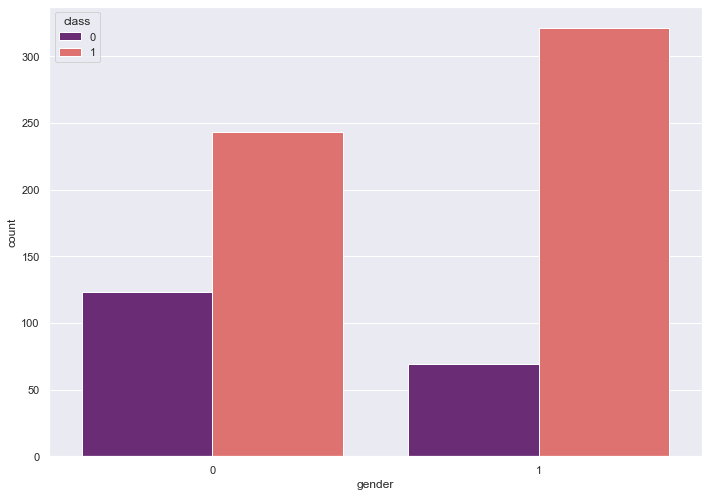

In [140]:
sns.countplot(data=pd_data, x='gender', hue='class',  palette = 'magma')

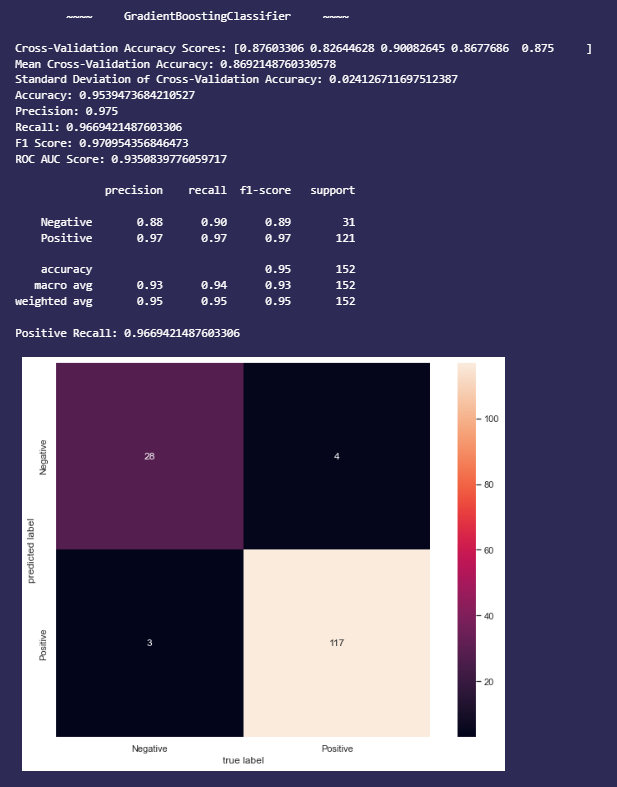 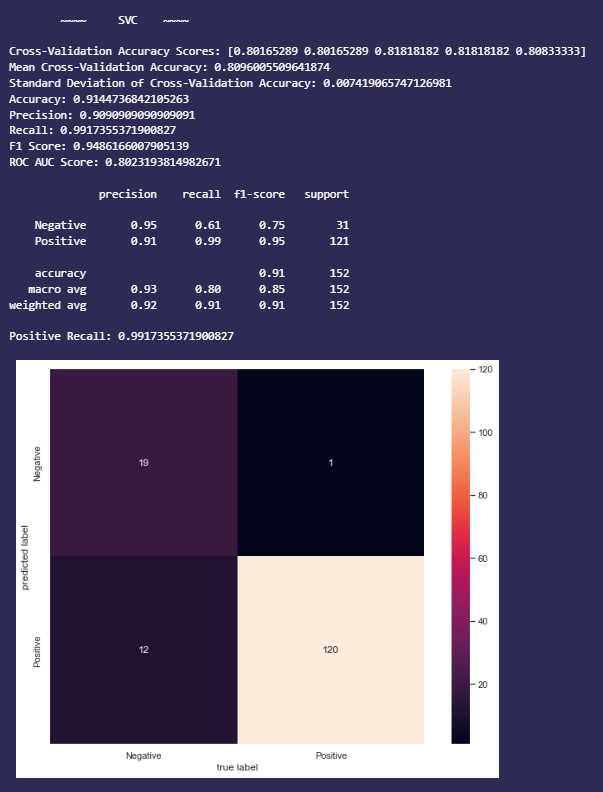

These models were the ones that stood out the most to me. The first model uses all the features, and the second uses the PCA data. These two models are tough to choose from. The main priority with this problem is a high recall of positive matches. The second has a high recall of true positives, but the first has a better recall of true negatives. With fewer false positives, there would be less strain on medical professionals. If this is just a preliminary screening model and other tests can be quickly done to verify the diagnosis, I suggest the second model. 




		 *** ALL Features ***




	~~~~	 RandomForestClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.83471074 0.80991736 0.89256198 0.8677686  0.875     ]
Mean Cross-Validation Accuracy: 0.8559917355371901
Standard Deviation of Cross-Validation Accuracy: 0.029708990856229255
Accuracy: 0.9342105263157895
Precision: 0.9512195121951219
Recall: 0.9669421487603306
F1 Score: 0.9590163934426229
ROC AUC Score: 0.8866968808317782 

              precision    recall  f1-score   support

    Negative       0.86      0.81      0.83        31
    Positive       0.95      0.97      0.96       121

    accuracy                           0.93       152
   macro avg       0.91      0.89      0.90       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9669421487603306


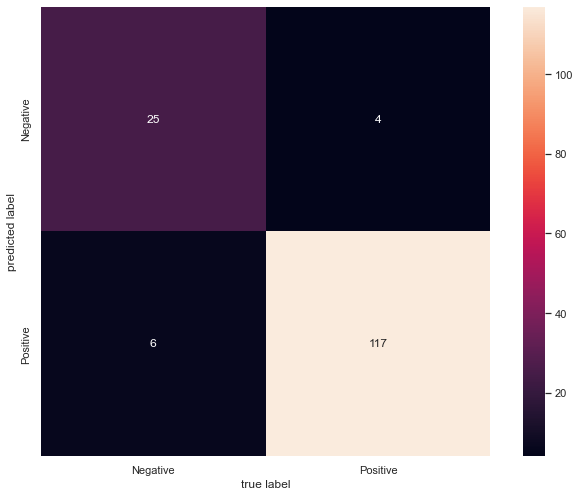


	~~~~	 LogisticRegression 	~~~~

Cross-Validation Accuracy Scores: [0.80991736 0.80991736 0.89256198 0.78512397 0.81666667]
Mean Cross-Validation Accuracy: 0.8228374655647382
Standard Deviation of Cross-Validation Accuracy: 0.036484938342986446
Accuracy: 0.8355263157894737
Precision: 0.9444444444444444
Recall: 0.8429752066115702
F1 Score: 0.890829694323144
ROC AUC Score: 0.8247134097573979 

              precision    recall  f1-score   support

    Negative       0.57      0.81      0.67        31
    Positive       0.94      0.84      0.89       121

    accuracy                           0.84       152
   macro avg       0.76      0.82      0.78       152
weighted avg       0.87      0.84      0.85       152

Positive Recall: 0.8429752066115702


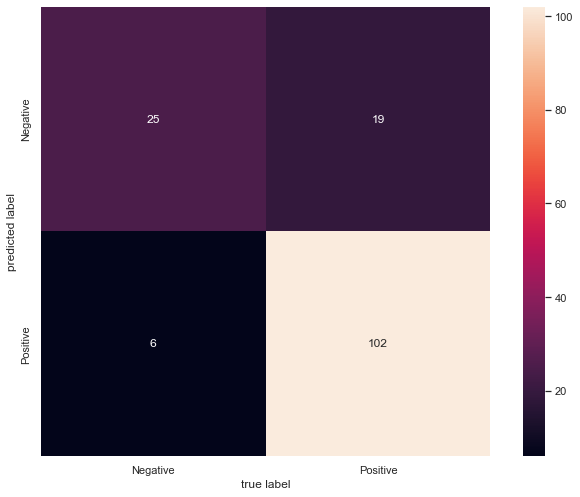


	~~~~	 GradientBoostingClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.87603306 0.82644628 0.90082645 0.8677686  0.875     ]
Mean Cross-Validation Accuracy: 0.8692148760330578
Standard Deviation of Cross-Validation Accuracy: 0.024126711697512387
Accuracy: 0.9539473684210527
Precision: 0.975
Recall: 0.9669421487603306
F1 Score: 0.970954356846473
ROC AUC Score: 0.9350839776059717 

              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.93      0.94      0.93       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


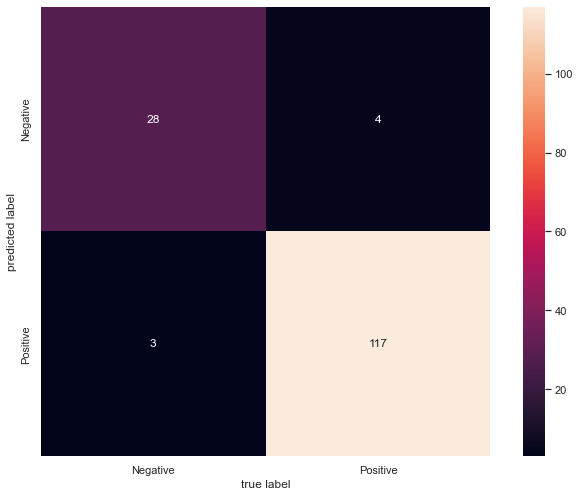


	~~~~	 SVC 	~~~~

Cross-Validation Accuracy Scores: [0.82644628 0.81818182 0.87603306 0.82644628 0.875     ]
Mean Cross-Validation Accuracy: 0.8444214876033058
Standard Deviation of Cross-Validation Accuracy: 0.025569799180834657
Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


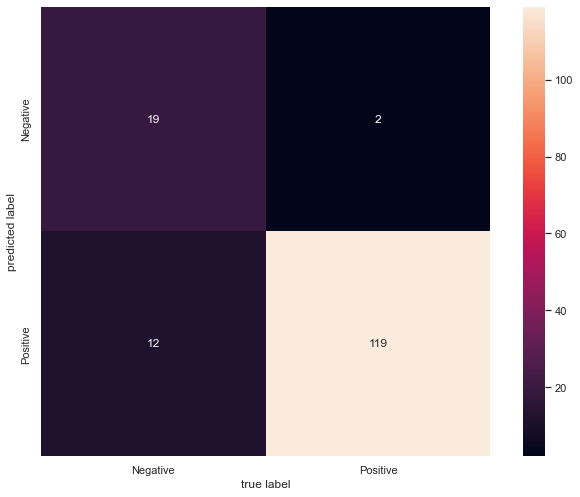


	~~~~	 GaussianNB 	~~~~

Cross-Validation Accuracy Scores: [0.68595041 0.76859504 0.73553719 0.72727273 0.71666667]
Mean Cross-Validation Accuracy: 0.7268044077134986
Standard Deviation of Cross-Validation Accuracy: 0.02681328226045258
Accuracy: 0.756578947368421
Precision: 0.9285714285714286
Recall: 0.7520661157024794
F1 Score: 0.8310502283105023
ROC AUC Score: 0.763129832044788 

              precision    recall  f1-score   support

    Negative       0.44      0.77      0.56        31
    Positive       0.93      0.75      0.83       121

    accuracy                           0.76       152
   macro avg       0.69      0.76      0.70       152
weighted avg       0.83      0.76      0.78       152

Positive Recall: 0.7520661157024794


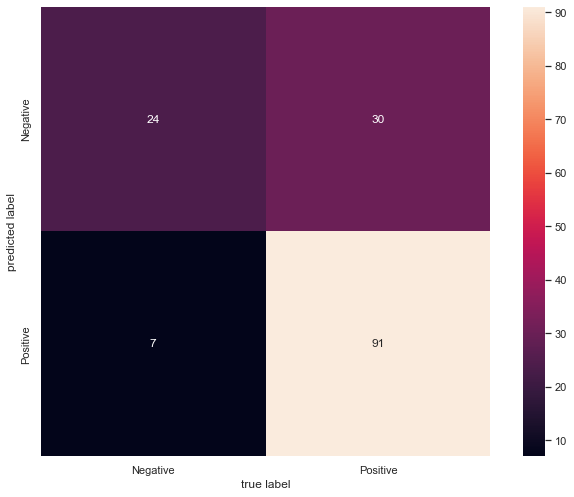

Best number of components to capture 90% variance: 117



		 *** PCA 117 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.76859504 0.7768595  0.80991736 0.79338843 0.76666667]
Mean Cross-Validation Accuracy: 0.7830853994490358
Standard Deviation of Cross-Validation Accuracy: 0.016397642082854665
Accuracy: 0.868421052631579
Precision: 0.8581560283687943
Recall: 1.0
F1 Score: 0.9236641221374046
ROC AUC Score: 0.6774193548387097 

              precision    recall  f1-score   support

    Negative       1.00      0.35      0.52        31
    Positive       0.86      1.00      0.92       121

    accuracy                           0.87       152
   macro avg       0.93      0.68      0.72       152
weighted avg       0.89      0.87      0.84       152

Positive Recall: 1.0


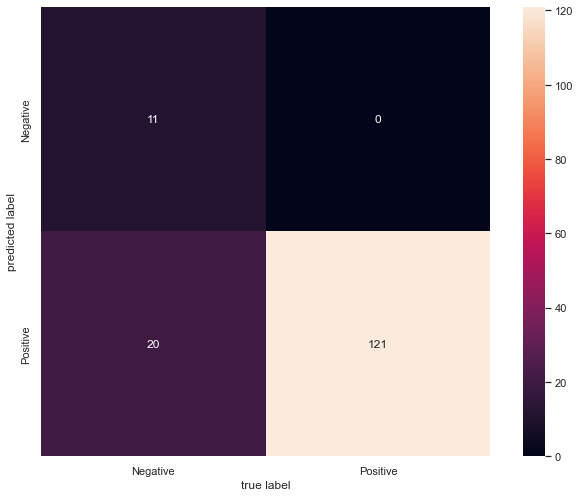


	~~~~	 LogisticRegression 	~~~~

Cross-Validation Accuracy Scores: [0.76859504 0.74380165 0.83471074 0.75206612 0.775     ]
Mean Cross-Validation Accuracy: 0.7748347107438016
Standard Deviation of Cross-Validation Accuracy: 0.03195484229198032
Accuracy: 0.8289473684210527
Precision: 0.905982905982906
Recall: 0.8760330578512396
F1 Score: 0.8907563025210083
ROC AUC Score: 0.7605971740869101 

              precision    recall  f1-score   support

    Negative       0.57      0.65      0.61        31
    Positive       0.91      0.88      0.89       121

    accuracy                           0.83       152
   macro avg       0.74      0.76      0.75       152
weighted avg       0.84      0.83      0.83       152

Positive Recall: 0.8760330578512396


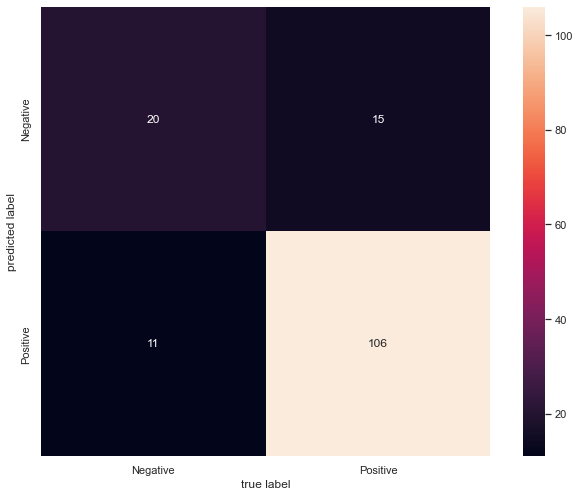


	~~~~	 GradientBoostingClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.83471074 0.85123967 0.87603306 0.81818182 0.825     ]
Mean Cross-Validation Accuracy: 0.8410330578512397
Standard Deviation of Cross-Validation Accuracy: 0.02072865009197685
Accuracy: 0.881578947368421
Precision: 0.8872180451127819
Recall: 0.9752066115702479
F1 Score: 0.9291338582677166
ROC AUC Score: 0.7456678219141561 

              precision    recall  f1-score   support

    Negative       0.84      0.52      0.64        31
    Positive       0.89      0.98      0.93       121

    accuracy                           0.88       152
   macro avg       0.86      0.75      0.78       152
weighted avg       0.88      0.88      0.87       152

Positive Recall: 0.9752066115702479


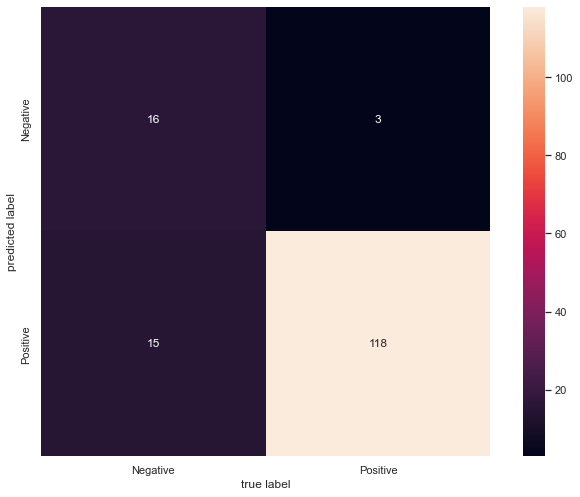


	~~~~	 SVC 	~~~~

Cross-Validation Accuracy Scores: [0.80165289 0.80165289 0.81818182 0.81818182 0.80833333]
Mean Cross-Validation Accuracy: 0.8096005509641874
Standard Deviation of Cross-Validation Accuracy: 0.007419065747126981
Accuracy: 0.9144736842105263
Precision: 0.9090909090909091
Recall: 0.9917355371900827
F1 Score: 0.9486166007905139
ROC AUC Score: 0.8023193814982671 

              precision    recall  f1-score   support

    Negative       0.95      0.61      0.75        31
    Positive       0.91      0.99      0.95       121

    accuracy                           0.91       152
   macro avg       0.93      0.80      0.85       152
weighted avg       0.92      0.91      0.91       152

Positive Recall: 0.9917355371900827


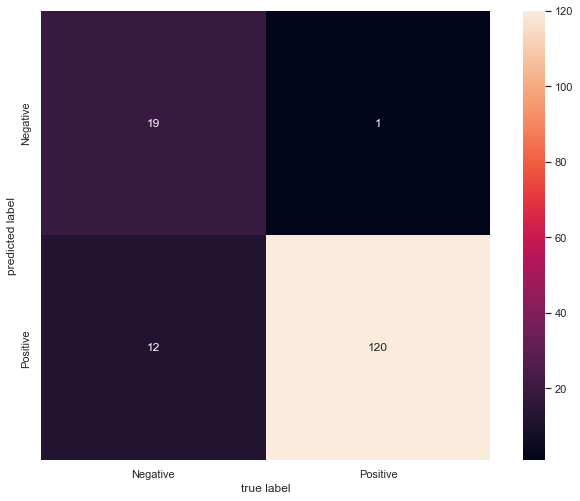


	~~~~	 GaussianNB 	~~~~

Cross-Validation Accuracy Scores: [0.40495868 0.74380165 0.62809917 0.80991736 0.71666667]
Mean Cross-Validation Accuracy: 0.6606887052341598
Standard Deviation of Cross-Validation Accuracy: 0.140549214740957
Accuracy: 0.7697368421052632
Precision: 0.9215686274509803
Recall: 0.7768595041322314
F1 Score: 0.8430493273542601
ROC AUC Score: 0.7593974940015995 

              precision    recall  f1-score   support

    Negative       0.46      0.74      0.57        31
    Positive       0.92      0.78      0.84       121

    accuracy                           0.77       152
   macro avg       0.69      0.76      0.71       152
weighted avg       0.83      0.77      0.79       152

Positive Recall: 0.7768595041322314


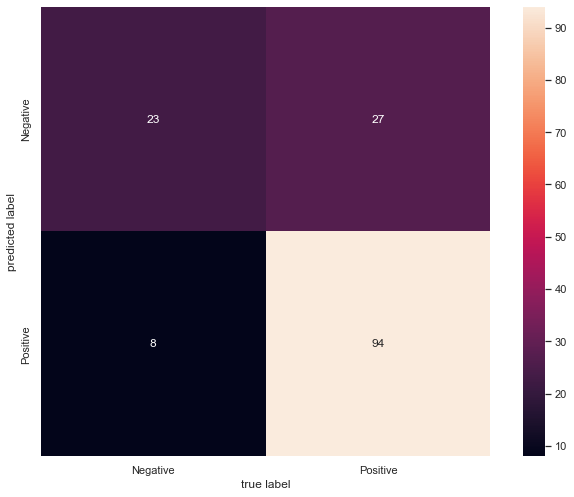

In [149]:
pd_data = get_data(pd_csv)

print('\n\n\n\t\t *** ALL Features ***\n\n\n')

evaluate_models(pd_data,
    [RandomForestClassifier(), 
     LogisticRegression(max_iter=1000),
     GradientBoostingClassifier(),
     SVC(),
     GaussianNB()])

best_num_components = find_best_num_components(pd_data, threshold=0.9)
print(f"Best number of components to capture 90% variance: {best_num_components}")

print('\n\n\n\t\t *** PCA', best_num_components, 'Components ***\n\n')

pd_data_pcs = get_pca(pd_data, best_num_components)

evaluate_models(pd_data_pcs,
    [RandomForestClassifier(), 
    LogisticRegression(max_iter=1000),
    GradientBoostingClassifier(),
    SVC(),
    GaussianNB()])
    